In [21]:
%matplotlib inline

import os
import string
import shutil
import random
import time

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras    import layers
from tensorflow.keras    import Model
from tensorflow.keras    import callbacks
from keras.preprocessing import image

from tensorflow.keras.optimizers          import RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
#script for organizing train and test folders
# adapted to my folder ornazation/ wont run on your pc

#create the train/test dirs
# run only once
#os.chdir('train')
os.listdir('/data/train')
for i in range(9):
    os.mkdir(i)

for i in string.ascii_lowercase:
    os.mkdir(i)

os.chdir("C:\Users\Doula\Desktop\Achref\Studium\SoS19\Deep Learning\project\deep_ml_project_19\implementation")

# automating file copy
#os.listdir('./data/train/')
data_dir='./data/train/'
#print(os.listdir(data_dir))
for file in os.listdir(data_dir):
    if file.endswith('.png'):
        for i in range(9):
            if file[6]==str(i):
                shutil.copy(data_dir+file, data_dir+str(i))
        for i in string.ascii_lowercase:
            if file[6]==i:
                shutil.copy(data_dir+file, data_dir+str(i))

# create test files
#shutil.move(source, destination)
data_src_dir='./data/train/'
data_snc_dir='./data/test/'
for drc in os.listdir(data_src_dir):
    for file in os.listdir(data_src_dir+drc):
        if file[17]==str(5):
            shutil.move(data_src_dir+drc+'/'+file, data_snc_dir+drc+'/'+file)



### Creating the variables

In [2]:
base_dir  = '.\\data'
train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Directory with our training num pictures
l=[str(i) for i in range(9)]+list(string.ascii_lowercase)

train_dir_list=[os.path.join(train_dir,str(i)) for i in l]
test_dir_list =[os.path.join(test_dir, str(i)) for i in l]

train_fnames_list =[list(os.listdir(train_dir_list[i])) for i in range(len(train_dir_list))]
test_fnames_list  =[list(os.listdir(test_dir_list[i]))  for i in range(len(test_dir_list)) ]

### Showing Some Samples from the Data Set

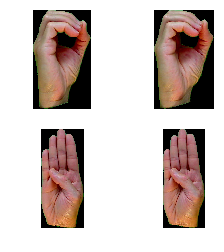

In [8]:
# Show some data from training set
nrows = 2
ncols = 2
# Index for iterating over images
pic_index = 0

# fig params
fig = plt.gcf()
fig.set_size_inches(ncols * 2, nrows * 2)

pic_index += 2
next_0_pix = [os.path.join(train_dir_list[0], fname)
                for fname in train_fnames_list[0][pic_index-2:pic_index]]
next_a_pix = [os.path.join(train_dir_list[10], fname)
                for fname in train_fnames_list[10][pic_index-2:pic_index]]

for i, img_path in enumerate(next_0_pix+next_a_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


### ConvNet

In [9]:
# input shape 200x200x3: 3 for R, G, B
img_input = layers.Input(shape=(200, 200, 3))

# 1st block of layers
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.25)(x)

# 2nd block of layers
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.25)(x)

# 3d block of layers
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.25)(x)

# flatten and dense
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# output layer with 36 neurons: one for each class
output = layers.Dense(36, activation='softmax')(x)

# loss as in the paper: categorical_crossentropy
model = Model(img_input, output)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 99, 99, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 156816)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               20072576  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

### Data Augmentation

In [18]:
# augmentation only for training images
# according to the paper: 20° rotation + 20% translation (both axes), flip horz
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=90,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')


Found 1976 images belonging to 36 classes.
Found 494 images belonging to 36 classes.
Wall time: 330 ms


### Train

In [22]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=198,  # nr images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/10
 - 74s - loss: 2.5846 - acc: 0.2013 - val_loss: 2.1872 - val_acc: 0.3198
Epoch 2/10
 - 73s - loss: 2.5520 - acc: 0.2064 - val_loss: 2.0114 - val_acc: 0.3320
Epoch 3/10
 - 73s - loss: 2.5995 - acc: 0.1966 - val_loss: 2.1213 - val_acc: 0.3178
Epoch 4/10
 - 73s - loss: 2.5139 - acc: 0.2113 - val_loss: 1.9953 - val_acc: 0.2955
Epoch 5/10
 - 78s - loss: 2.5430 - acc: 0.2081 - val_loss: 2.0571 - val_acc: 0.3259
Epoch 6/10
 - 73s - loss: 2.5277 - acc: 0.2204 - val_loss: 2.2104 - val_acc: 0.3219
Epoch 7/10
 - 72s - loss: 2.5356 - acc: 0.2045 - val_loss: 2.5387 - val_acc: 0.3198
Epoch 8/10
 - 72s - loss: 2.5500 - acc: 0.2128 - val_loss: 2.1638 - val_acc: 0.3219
Epoch 9/10
 - 72s - loss: 2.5396 - acc: 0.2234 - val_loss: 1.9275 - val_acc: 0.3320
Epoch 10/10
 - 74s - loss: 2.5073 - acc: 0.2076 - val_loss: 2.3202 - val_acc: 0.3178
Wall time: 12min 15s


### Evaluate The Model

Test accuracy:31.78 %


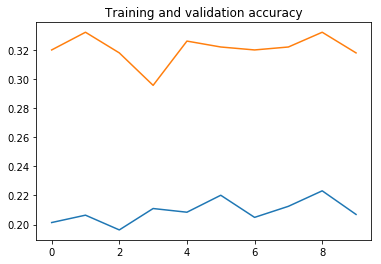

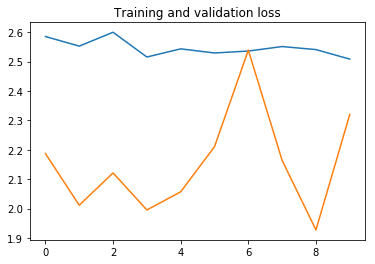

In [34]:
acc     = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

# print accuracy
test_loss, test_acc = model.evaluate_generator(validation_generator)
test_acc*=100
print('Test accuracy:%.2f' % test_acc,'%')

### Check intermediate states

c:\users\doula\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


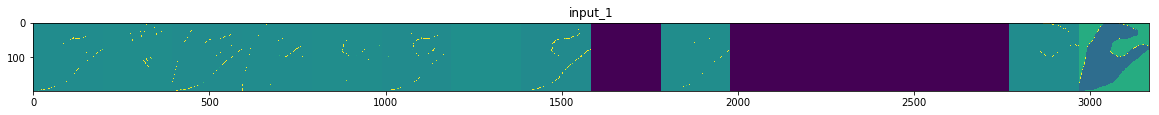

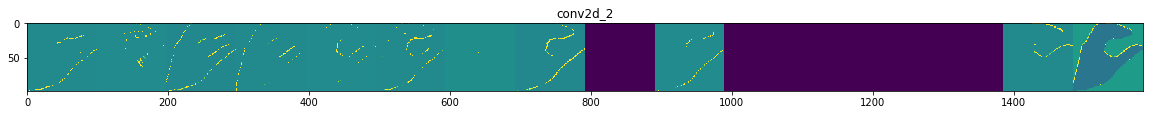

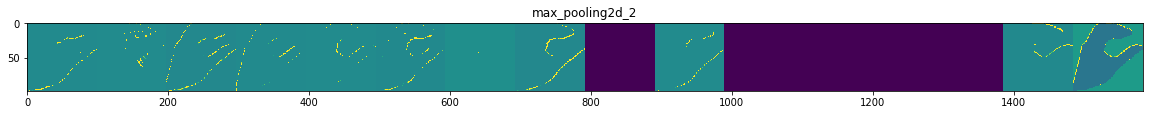

In [24]:
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# random inputs from training set (1 and b images)
img_1_files = train_fnames_list[1]
img_c_files = train_fnames_list[11]
img_path =train_dir_list[11]+'\\'+ random.choice( img_c_files)

img = load_img(img_path, target_size=(200, 200))  # this is a PIL image
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# Rescale by 1/255
x /= 255

# intermediate representations
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')



### Perform Single Predictions

Predicted Class is:  c


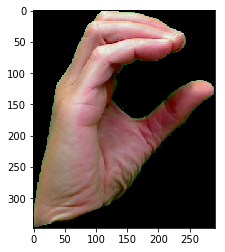

In [25]:
# path of images to be test

# reverse class dictionary
class_dictionary = train_generator.class_indices
class_dictionary_reversed={v: k for k, v in class_dictionary.items()}

# path of images to be test
timg_path=img_path
img = mpimg.imread(timg_path)
plt.imshow(img)

timg = load_img(timg_path, target_size=(200, 200))
timg = image.img_to_array(timg)
timg=timg.reshape((1,)+timg.shape)

# Add the image to a batch where it's the only member
timg/=255
predictions_single = model.predict(timg)

item_class=np.argmax(predictions_single[0])
print("Predicted Class is: ",class_dictionary_reversed[item_class])


### Save the Model when performig well

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5\n",
model.save_weights("model.h5")
print("Saved model to disk")

### Performing a Grid Search

In [ ]:
# TODO


def gridSearch(model,params_list,values_list):
    history = model.fit_generator(
      train_generator,
      steps_per_epoch=198,  # nr images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')